In [1]:
#Descomentar la siguiente línea si se corre desde Google Colaboratory / Uncomment next line if run from Google Colaboratory
#!pip install -U PyYAML datashader

# A-Feigenbaum

(english below)

Este programa muestra la función logística $f(x)=rx(1-1)$ y su diagrama de bifurcaciones. Este último tiene en el eje-$x$ los valores para el parámetro $r$. En el eje-$y$ están los valores que $f(x)$ puede tomar.

Este es un ejemplpo de un mapeo que al iterarse se vuelve caótico para ciertos valores de $r$. Se puede observar que al tomar valores de $r$ cada vez más grandes, el mapeo transiciona cada vez más rápido de no-caótica a caótica y de regreso, hasta culminar con $r=4$ siendo caótica.

También se muestra el diagrama del exponente de Lyapunov para cada valor de $r$. Cuando este es positivo, significando que la separación entre dos órbitas contiguas crece exponencialmente con esa potencia, entonces el mapeo es caótico.

--

This program shows the logistic function $f(x)=rx(1-1)$ and its bifurcation diagram. The later has on the $x$-axis the values for the parameter $r$. On the $y$-axis are the values that $f(x)$ can take.

This is an example of a mapping that upon iteration becomes chaotic for certain values of $r$. It can be observed that by taking larger and larger values of $r$, the mapping transitions faster and faster from non-chaotic to chaotic and back, until it finishes with $r=4$ being chaotic.

Also shown is the plot of the Lyapunov exponent for each value of $r$. When this is positive, meaning that the separation between two contiguous orbits grows exponentially with that power, then the mapping is chaotic.


In [2]:
import numpy as np, pandas as pd, datashader as ds, xarray as xr
from datashader import transfer_functions as tf
from datashader.colors import inferno, viridis, Hot
from numba import jit
from datashader.utils import export_image

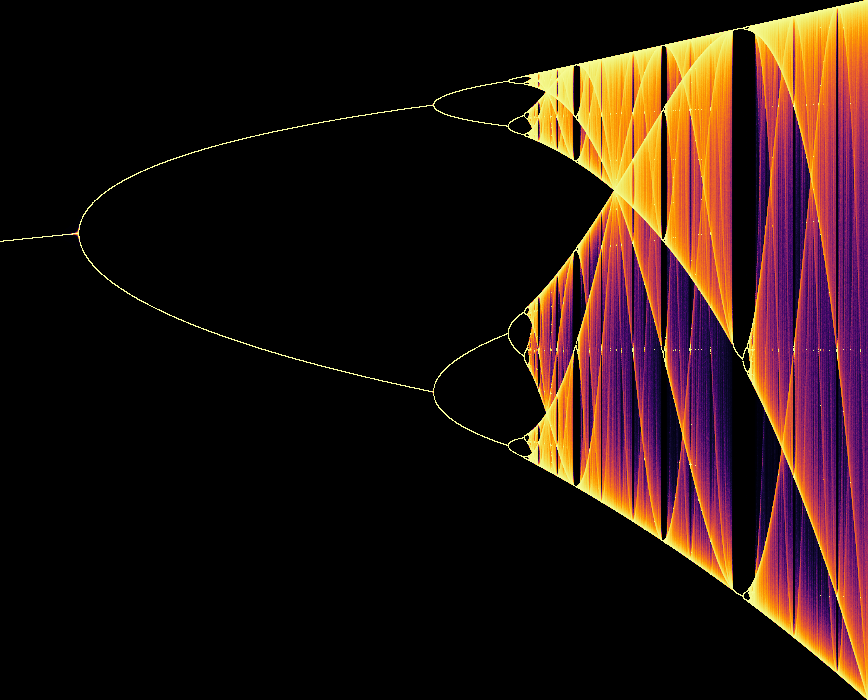

In [3]:
@jit(nopython=True)
def logistica(r, x0=0.2, nvalues=100):
    #evalua = np.frompyfunc(lambda x, _: r*x*(1-x), 2, 1)
    #evalua = lambda x: r*x*(1-x), 2, 1 
    orb = np.empty(nvalues)
    orb[0] = x0
    for i in range(nvalues-1):
        x = orb[i]
        orb[i+1] = r * x * (1 - x)
    return orb

def feigenbaum(f, minimo=0, maximo=4, nr=10000, n=100000):
    ds.transfer_functions.Image.border=0
    cv = ds.Canvas(plot_width = 868, plot_height = 700)
    erres = np.linspace(minimo, maximo, nr, endpoint=True)
    xs = np.repeat(erres, n)
    ys = np.concatenate([f(r, x0=f(r)[-1], nvalues=n) for r in erres])
    df = pd.DataFrame({'x':xs, 'y':ys})
    xs, ys, erres = [None]*3  # desocupa variables temporales
    agg = cv.points(df, 'x', 'y')
    # add lines
    df1 = pd.DataFrame({'a':[2.95]*4, 'y1':[0,0.5,1, 0], 'b':[3.2]*4, 'c':[3.5]*4})
    feig = tf.shade(agg, cmap=inferno)
    return tf.set_background(feig, "black")

img = feigenbaum(logistica, 2.9, 4)
img #export_image(img=img, filename="feig", fmt=".png", export_path="./")

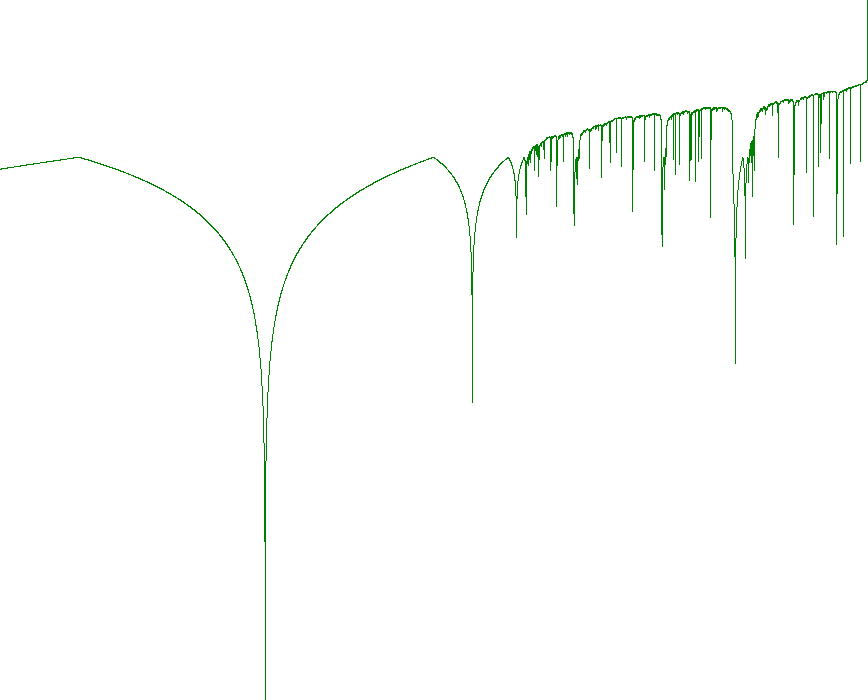

In [4]:
@jit(nopython=True)
def lyapunov(x=0.5, r=4.0):
    for i in range(1000): x = r * x * (1 - x)
    NLYAP = 1000000
    total = 0
    for _ in range(NLYAP):
        x = r * x * (1 - x)
        total += np.log2(np.abs(r - 2 * r * x))
    return total / NLYAP
cv = ds.Canvas(plot_width = 868, plot_height = 700)
xs = np.linspace(2.9, 4, 10000)
ys = [lyapunov(r=r) for r in xs]
df = pd.DataFrame({'x':xs, 'y':ys})
#plt.plot(x, np.zeros_like(x))
agg = cv.line(df, 'x', 'y')
img = tf.shade(agg, cmap=['green'])
img #export_image(img=img, filename="lyap", fmt=".png", export_path="./")